# Preprocessing

In [167]:
import csv
import numpy as np
import matplotlib.pyplot as plt

featureLabels = set([
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course"
])
featureMaps = {}
reverseMaps = {}
featureMaps["gender"] = {
    "male"   : [0],
    "female" : [1]
}
featureMaps["race/ethnicity"] = {
    "group A" : [1, 0, 0, 0, 0],
    "group B" : [0, 1, 0, 0, 0],
    "group C" : [0, 0, 1, 0, 0],
    "group D" : [0, 0, 0, 1, 0],
    "group E" : [0, 0, 0, 0, 1]
}
featureMaps["parental level of education"] = {
    "some high school"   : [1, 0, 0, 0, 0, 0],
    "some college"       : [0, 1, 0, 0, 0, 0],
    "bachelor's degree"  : [0, 0, 1, 0, 0, 0],
    "master's degree"    : [0, 0, 0, 1, 0, 0],
    "high school"        : [0, 0, 0, 0, 1, 0],
    "associate's degree" : [0, 0, 0, 0, 0, 1]
}
featureMaps["lunch"] = {
    "standard"     : [0],
    "free/reduced" : [1]
}
featureMaps["test preparation course"] = {
    "none"      : [0],
    "completed" : [1]
}
for key in featureMaps:
    reverseMaps[key] = {str(v): k for k, v in featureMaps[key].iteritems()}

regressionLabels = set([
    "math score",
    "reading score",
    "writing score"
])

def featuresToVector(features, usedFeatures = None):
    """
    features is a dictionary with keys in featureLabels above
    Takes the features and returns a vector (array of 1's/0's corresponding to it)
    """
    if usedFeatures is None:
        usedFeatures = featureLabels
    result = []
    for label in usedFeatures:
        currMap = featureMaps[label]
        currVal = features[label]
        result += currMap[currVal]
    return result

def vectorToFeatures(v, usedFeatures = None):
    """
    Exactly the reverse of the function above.
    """
    if usedFeatures is None:
        usedFeatures = featureLabels
    result = {}
    vTmp = v
    for label in usedFeatures:
        currMap = featureMaps[label]
        currLen = len(currMap.values()[0])
        currVector = vTmp[:currLen]
        vTmp       = vTmp[currLen:]
        currReverseMap = reverseMaps[label]
        result[label] = currReverseMap[str(currVector)]
    return result

def testFeatureConversions():
    """
    Test to check that feature conversions work (featuresToVector and vectorToFeatures)
    """
    with open('students-performance-in-exams/StudentsPerformance.csv', 'rb') as f:
        csvReader = csv.DictReader(f)
        for features in csvReader:
            currVector = featuresToVector(features)
            currFeatures = vectorToFeatures(currVector)
            for label in featureLabels:
                assert features[label] == currFeatures[label]
                
def addOneCol(XOld):
    mOld, nOld = XOld.shape
    X = np.ones( (mOld, nOld + 1) )
    X[:, :-1] = XOld
    return X
                
def calcDataMatrix(usedFeatures = None):
    """
    Returns the X matrix used in linear regression. Adds in the 1 term at the end.
    """
    result = []
    with open('students-performance-in-exams/StudentsPerformance.csv', 'rb') as f:
        csvReader = csv.DictReader(f)
        for features in csvReader:
            currVector = featuresToVector(features, usedFeatures)
            result.append(currVector)
    return np.array(result)

def calcOutputVector(label):
    """
    Returns a y vector on label. label can be any value from regressionLabels
    """
    assert label in regressionLabels
    
    result = []
    with open('students-performance-in-exams/StudentsPerformance.csv', 'rb') as f:
        csvReader = csv.DictReader(f)
        for features in csvReader:
            result.append(int(features[label]))
    return np.array(result, ndmin=2).T


# Uncomment to test feature conversions
# testFeatureConversions()

# X is the data vector from preprocessing
X = addOneCol(calcDataMatrix())
print X.shape

(1000L, 15L)


## Utility Functions

In [202]:
def makeScatterPlot(title, pointsLists, colors, markers, xlabel = '', ylabel = ''):
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
     
    for i, pointsList in enumerate(pointsLists):
        currColor = colors[i]
        currMarker = markers[i]
        for point in pointsList:
            x, y = point
            ax.scatter(x, y, c=currColor, marker=currMarker)
        
    # Temporary, add line
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = 0 + 1 * x_vals
    plt.plot(x_vals, y_vals, '--')
    
    # plt.xlim(0, 100)
    # plt.ylim(0, 100)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=2)
    plt.show()

def calcError(y1, y2):
    return (y1 - y2) ** 2

def performValidation(k, X, y, model, plotDiffs = False):
    """
    Performs cross validation
    """
    # Set things up
    table = {}
    for i, row in enumerate(X):
        table[str(row)] = y[i]
    predTable = {}
    
    # Split X up into folds
    stepSize = int(X.shape[0] / k) + 1
    steps = [min(X.shape[0], stepSize * n) for n in range(1, k)]
    folds = np.split(X, steps)
    foldLabels = np.split(y, steps)
    
    # For each fold i, use i as testing, and use all the other
    # i - 1 folds for training. Calculate the errors for each and store
    # them in avgErrors
    avgErrors = []
    for i, currFold in enumerate(folds):
        # Get XTrain and yTrain with all the other folds except currFold
        otherFolds = [otherFold for j, otherFold in enumerate(folds) if j != i]
        otherFoldLabels = [label for j, label in enumerate(foldLabels) if j != i]
        XTrain = otherFolds[0]
        yTrain = otherFoldLabels[0]
        for j in range(1, len(otherFolds)):
            XTrain = np.append(XTrain, otherFolds[j], axis=0)
            yTrain = np.append(yTrain, otherFoldLabels[j], axis=0)
            
        # Train the model
        model.fit(XTrain, yTrain)
        
        # Now, evaluate the trained model against the actual labels,
        # keep track of total error!
        totalError = 0
        for row in currFold:
            
            # Get the current predicted value
            currRow = row.reshape(1, -1)
            yPredicted = model.predict(currRow)
            
            totalError += calcError(yPredicted[0], table[str(row)][0])
            predTable[str(row)] = yPredicted
        totalError /= len(currFold)
        avgErrors.append(totalError)
          
    predictions = []
    actuals = []
    plotPoints = []
    for row in X:
        hashVal = str(row)
        predictions.append(predTable[hashVal][0])
        actuals.append(table[hashVal][0])
    plotPoints = [(predictions[i], actuals[i]) for i in range(len(actuals))]

    # Optionally, plot the measured vs predicted values
    if plotDiffs:
        title = "Measured vs Predicted"
        pointsLists = [plotPoints]
        colors = ['r']
        markers = ['.']
        xlabel = 'Predicted'
        ylabel = 'Actual'
        makeScatterPlot(title, 
                        pointsLists, 
                        colors, 
                        markers,
                        xlabel,
                        ylabel)
    return avgErrors

def validateOnLabel(label, X, k, trainFunc):
    """
    Perform cross validation on any label in regressionLabels
    """
    y = calcOutputVector(label)
    w = trainFunc(X, y)
    avgErrors = performValidation(k, X, y, trainFunc, plotDiffs = True)
    finalAvgError = np.mean(avgErrors)
    print "The average prediction error is {}".format(finalAvgError)


# Linear Regression

useScikit = True


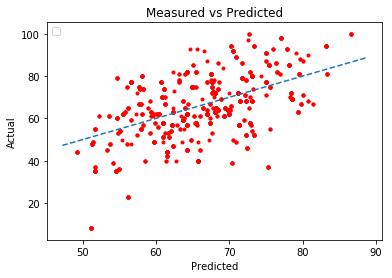

The average prediction error is 169.524563358
useScikit = False


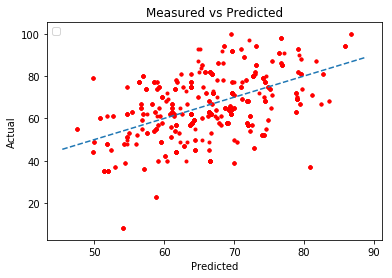

The average prediction error is 178.559450019


In [203]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

class LSModel(object):
    def __init__(self):
        self.X = None
        self.y = None
        self.w = None
        self.coef_ = None
        
    def LSTrain(self, X, y):
        # Calculate w = (X^tX)^{-1}X^tY and return it
        w = np.matmul(
                np.linalg.inv(np.matmul(X.T, X)),
                np.matmul(X.T, y)
        )
        return w
    
    def fit(self, X, y):
        self.X = addOneCol(X)
        self.y = y
        self.w = self.LSTrain(self.X, self.y)
        self.coef_ = self.w
        
    def predict(self, x):
        xNew = addOneCol(x).T
        result = [0]
        result = np.matmul(
            self.w.T,
            xNew
        )
        return result

for useScikit in [True, False]:
    print "useScikit = {}".format(useScikit)
    X = calcDataMatrix()
    X = preprocessing.scale(X, axis = 1)
    k = 5
    label = "math score"
    y = calcOutputVector(label)
    if useScikit:
        model = LinearRegression()
    else:
        model = LSModel()
    model.fit(X, y)
    avgErrors = performValidation(k, X, y, model, plotDiffs = True)
    finalAvgError = np.mean(avgErrors)
    print "The average prediction error is {}".format(finalAvgError)


# Ridge Regression, Bill Lee

# Lasso Regression